In [1]:
!pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894086 sha256=9105b52cd65db3c6cf91cd66c21a2318398385032e38973e959f35cda52d488d
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [2]:
import skfuzzy as fz
from skfuzzy import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
import ast

In [329]:
from re import S
class Fuzzy:
    def __init__(self, fileName, splitChar=',') -> None:
        self.infos = self.readInfos(fileName, splitChar)

    def readInfos(self, fileName, splitChar=',') -> list:
        file1 = open(fileName, 'r')
        Lines = file1.readlines()
        info = []

        for line in Lines:
            l = line.strip().split(splitChar)
            l = list(map(str.strip, l))
            info.append(l)

        return info

    def cleanInfos(self) -> dict:
        self.universes = {
            "antecedent": {
                "qPa": [],
                "pulse": [],
                "resp": []
            },
            "consequent": {
                "gravity": []
            }
        }
        
        
        for i in self.infos:
            self.universes["antecedent"]["qPa"].append(float(i[3]))
            self.universes["antecedent"]["pulse"].append(float(i[4]))
            self.universes["antecedent"]["resp"].append(float(i[5]))
            self.universes["consequent"]["gravity"].append(float(i[6]))
        return self.universes

    def transformToControls(self) -> dict:
        for k, v in self.universes["antecedent"].items():
            self.universes["antecedent"][k] = ctrl.Antecedent(np.array(v), k)

        self.universes["consequent"]["gravity"] = ctrl.Consequent(
            np.array(self.universes["consequent"]["gravity"]), "gravity")
        return self.universes
    
    def membership(self) -> dict:
        self.membershipPulse()
        self.membershipResp()
        self.membershipQPa()
        self.membershipGravity()
        return self.universes
    
    def membershipPulse(self):
          universe = self.universes["antecedent"]["pulse"].universe
          self.universes["antecedent"]["pulse"]["LOW"] = fz.sigmf( universe, np.mean( universe),np.mean( universe))
          self.universes["antecedent"]["pulse"]["STABLE"] = fz.gaussmf( universe, np.mean( universe), np.std( universe))
          self.universes["antecedent"]["pulse"]["HIGH"] = fz.pimf( universe, np.std(universe),np.max(universe)*1.5,np.max( universe)*1.5,np.max( universe)*2)

    def membershipResp(self):
          universe = self.universes["antecedent"]["resp"].universe
          self.universes["antecedent"]["resp"]["LOW"] = fz.sigmf( universe, np.mean( universe),np.mean( universe)*1.5)
          self.universes["antecedent"]["resp"]["STABLE"] = fz.gaussmf( universe, np.mean( universe), np.std( universe))
          self.universes["antecedent"]["resp"]["HIGH"] = fz.pimf( universe, np.std(universe),np.max( universe)*1.5,np.max( universe)*1.5,np.max( universe)*2)
          
    def membershipQPa(self):
          self.universes["antecedent"]["qPa"].automf(names=["DANGER","STABLE"])
          
    def membershipGravity(self):
        self.universes["consequent"]["gravity"].automf(names=["CRITICAL","UNSTABLE","POTENTIALLY UNSTABLE","STABLE"])
    
    def generate_rule(self) -> dict:
        rules = []
        for i in self.infos:
            listX1 , listX2, listX3 ,listY = [],[],[],[]
            qPa,pulse,resp, gravity = float(i[3]),float(i[4]),float(i[5]),float(i[6])
            #qPA
            listX1.append(fz.interp_membership(self.universes["antecedent"]["qPa"].universe,
                                                self.universes["antecedent"]["qPa"]["DANGER"].mf,
                                                qPa))
            listX1.append(fz.interp_membership(self.universes["antecedent"]["qPa"].universe,
                                                self.universes["antecedent"]["qPa"]["STABLE"].mf,
                                                qPa))
           
            #resp            
            listX2.append(fz.interp_membership(self.universes["antecedent"]["resp"].universe,
                                                self.universes["antecedent"]["resp"]["LOW"].mf,
                                                resp))
            listX2.append(fz.interp_membership(self.universes["antecedent"]["resp"].universe,
                                                self.universes["antecedent"]["resp"]["STABLE"].mf,
                                                resp))
            listX2.append(fz.interp_membership(self.universes["antecedent"]["resp"].universe,
                                                self.universes["antecedent"]["resp"]["HIGH"].mf,
                                                resp))
            #pulse
            listX3.append(fz.interp_membership(self.universes["antecedent"]["pulse"].universe,
                                                self.universes["antecedent"]["pulse"]["LOW"].mf,
                                                pulse))
            listX3.append(fz.interp_membership(self.universes["antecedent"]["pulse"].universe,
                                                self.universes["antecedent"]["pulse"]["STABLE"].mf,
                                                pulse))
            listX3.append(fz.interp_membership(self.universes["antecedent"]["pulse"].universe,
                                                self.universes["antecedent"]["pulse"]["HIGH"].mf,
                                                pulse))

            #gravity
            listY.append(fz.interp_membership(self.universes["consequent"]["gravity"].universe,
                                                self.universes["consequent"]["gravity"]["CRITICAL"].mf,
                                                gravity))
            listY.append(fz.interp_membership(self.universes["consequent"]["gravity"].universe,
                                                self.universes["consequent"]["gravity"]["UNSTABLE"].mf,
                                                gravity))
            listY.append(fz.interp_membership(self.universes["consequent"]["gravity"].universe,
                                                self.universes["consequent"]["gravity"]["POTENTIALLY UNSTABLE"].mf,
                                                gravity))
            listY.append(fz.interp_membership(self.universes["consequent"]["gravity"].universe,
                                                self.universes["consequent"]["gravity"]["STABLE"].mf,
                                                gravity))

            x1Max , x2max , x3max, ymax = np.argmax(listX1) , np.argmax(listX2), np.argmax(listX3), np.argmax(listY)
            degree = listX1[x1Max] * listX2[x2max] * listX3[x3max] * listY[ymax]
            rules.append([x1Max,x2max,x3max , ymax , degree])

        print('primitive Rules:')
        print('we have',len(rules),'rules!','\n')
        
        '''rules.sort(key= lambda rules:rules[0],reverse=True)
        rules.sort(key= lambda rules:rules[1],reverse=True)
        rules.sort(key= lambda rules:rules[2],reverse=True)
        rules.sort(key= lambda rules:rules[3],reverse=True)
        '''
        unique = np.unique(rules, axis=0)
        print('unique rule: ')
        print(len(unique))
        
        clean = {}
        for i in unique:
          t = str(i[:-1])
          if t not in clean:
            clean[t] = i[-1]
          elif clean[t] < i[-1]:
            clean[t] = i[-1] 
        
        print('finall rules: ')
        print(len(clean))
        self.array_rule = clean
        return clean

    def parseRules(self) -> list:
      self.rules = []
      qPa = self.universes["antecedent"]["qPa"]
      pulse = self.universes["antecedent"]["pulse"]
      resp =  self.universes["antecedent"]["resp"]
      gravity = self.universes["consequent"]["gravity"]
      print(self.array_rule)
      for i in self.array_rule:
          l = [float(x) for x in i[1:-1].split()]
          _qPa = self.convertRule(l[0], True)
          _pulse = self.convertRule(l[1])
          _resp = self.convertRule(l[2])
          _gravity =self.convertRuleG(l[3])
          self.rules.append(ctrl.Rule(qPa[_qPa] | pulse[_pulse] | resp[_resp],gravity[_gravity] ))
      return self.rules

    
    def convertRule(self, i, qPa=False):
      if i == 0: 
        return "LOW" if qPa == False else "DANGER" 
      if i == 1: 
       return "STABLE" if qPa == False else "STABLE" 
      if i == 2:
       return "HIGH" 

    def convertRuleG(self, i):
      if i == 0: 
        return "CRITICAL"
      if i == 1:
       return "UNSTABLE"
      if i == 2:
       return "POTENTIALLY UNSTABLE"
      if i == 3:
       return "STABLE"

    def createRules(self) -> list:
        self.rules = []
        qPa = self.universes["antecedent"]["qPa"]
        pulse = self.universes["antecedent"]["pulse"]
        resp =  self.universes["antecedent"]["resp"]
        gravity = self.universes["consequent"]["gravity"]
        
        self.rules.append(ctrl.Rule(qPa["DANGER"] & pulse["LOW"] & resp["LOW"],gravity["CRITICAL"]))
        
        self.rules.append(ctrl.Rule(qPa["DANGER"] & pulse["HIGH"]& resp["HIGH"],gravity["CRITICAL"]))

        self.rules.append(ctrl.Rule(qPa["DANGER"] & pulse["LOW"] & resp["HIGH"],gravity["CRITICAL"]))

        self.rules.append(ctrl.Rule(qPa["DANGER"] & pulse["HIGH"]& resp["LOW"],gravity["CRITICAL"]))

        self.rules.append(ctrl.Rule(qPa["DANGER"] & pulse["STABLE"]& resp["HIGH"],gravity["UNSTABLE"]))

        self.rules.append(ctrl.Rule(qPa["DANGER"] & pulse["STABLE"]& resp["LOW"],gravity["UNSTABLE"]))

        self.rules.append(ctrl.Rule(qPa["DANGER"] & pulse["HIGH"]& resp["STABLE"],gravity["UNSTABLE"]))

        self.rules.append(ctrl.Rule(qPa["DANGER"] & pulse["LOW"]& resp["STABLE"],gravity["UNSTABLE"]))

        self.rules.append(ctrl.Rule(qPa["DANGER"] & pulse["STABLE"]& resp["STABLE"],gravity["POTENTIALLY UNSTABLE"]))
        
        self.rules.append(ctrl.Rule(qPa["STABLE"] & pulse["LOW"] & resp["LOW"],gravity["UNSTABLE"]))
        
        self.rules.append(ctrl.Rule(qPa["STABLE"] & pulse["HIGH"]& resp["HIGH"],gravity["UNSTABLE"]))

        self.rules.append(ctrl.Rule(qPa["STABLE"] & pulse["LOW"] & resp["HIGH"],gravity["UNSTABLE"]))

        self.rules.append(ctrl.Rule(qPa["STABLE"] & pulse["HIGH"]& resp["LOW"],gravity["UNSTABLE"]))

        self.rules.append(ctrl.Rule(qPa["STABLE"] & pulse["STABLE"]& resp["HIGH"],gravity["POTENTIALLY UNSTABLE"]))

        self.rules.append(ctrl.Rule(qPa["STABLE"] & pulse["STABLE"]& resp["LOW"],gravity["POTENTIALLY UNSTABLE"]))

        self.rules.append(ctrl.Rule(qPa["STABLE"] & pulse["HIGH"]& resp["STABLE"],gravity["POTENTIALLY UNSTABLE"]))

        self.rules.append(ctrl.Rule(qPa["STABLE"] & pulse["LOW"]& resp["STABLE"],gravity["POTENTIALLY UNSTABLE"]))

        self.rules.append(ctrl.Rule(qPa["STABLE"] & pulse["STABLE"]& resp["STABLE"],gravity["STABLE"]))
        
        
        return self.rules
    
    def createSystem(self) :
        self.system = ctrl.ControlSystem(rules=self.rules)
        return self.system

    def createSimulation(self):
      self.sim =  ctrl.ControlSystemSimulation(self.system)
      return self.sim
    
    def simulation(self):
      index = 1
      print("index | anwser | fuzz")
      for i in self.infos:
        try:
          self.sim.input["qPa"] = float(i[3])
          self.sim.input["pulse"] = float(i[4])
          self.sim.input["resp"] = float(i[5])
          self.sim.compute() 
          print("{} | {} | {}".format(index, float(i[6]),self.sim.output["gravity"]))
        except:
          print("error in index {}, from: {} , {}".format(index, i[4], i[5]))
        index += 1

In [330]:
fuzz = Fuzzy('historicoGravidadeLabel.txt', "|")
infos = fuzz.cleanInfos()
controls = fuzz.transformToControls()
membership = fuzz.membership()
#rules  = fuzz.createRules()
#sys = fuzz.createSystem()
#sim = fuzz.createSimulation()

In [331]:
k = fuzz.generate_rule()

primitive Rules:
we have 800 rules! 

unique rule: 
11
finall rules: 
8


In [332]:
fuzz.parseRules()
sys = fuzz.createSystem()
sim = fuzz.createSimulation()

{'[0. 0. 0. 0.]': 0.0, '[0. 0. 0. 1.]': 0.3548089720350118, '[0. 0. 1. 0.]': 0.0, '[0. 0. 1. 1.]': 0.0, '[0. 1. 0. 0.]': 0.0, '[0. 1. 0. 1.]': 0.0, '[0. 1. 1. 0.]': 0.0, '[0. 1. 1. 1.]': 0.6243203973754534}


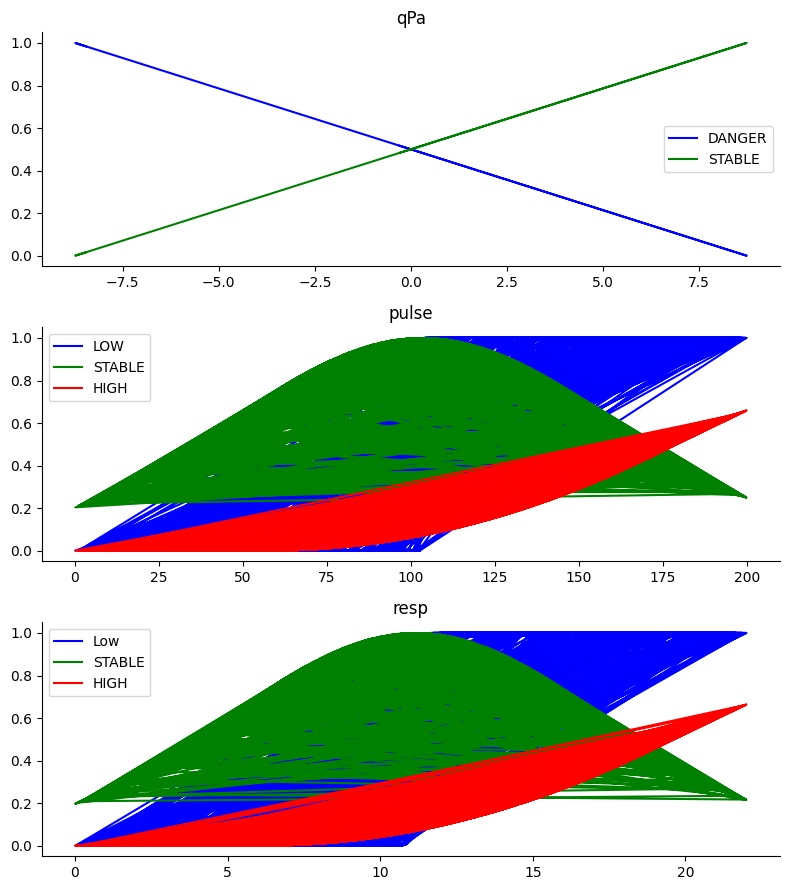

In [333]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(membership["antecedent"]["qPa"].universe, membership["antecedent"]["qPa"]["DANGER"].mf, 'b', linewidth=1.5, label='DANGER')
ax0.plot(membership["antecedent"]["qPa"].universe,  membership["antecedent"]["qPa"]["STABLE"].mf, 'g', linewidth=1.5, label='STABLE')
ax0.set_title('qPa')
ax0.legend()

ax1.plot(membership["antecedent"]["pulse"].universe, membership["antecedent"]["pulse"]["LOW"].mf, 'b', linewidth=1.5, label='LOW')
ax1.plot(membership["antecedent"]["pulse"].universe, membership["antecedent"]["pulse"]["STABLE"].mf, 'g', linewidth=1.5, label='STABLE')
ax1.plot(membership["antecedent"]["pulse"].universe, membership["antecedent"]["pulse"]["HIGH"].mf, 'r', linewidth=1.5, label='HIGH')
ax1.set_title('pulse')
ax1.legend()

ax2.plot(membership["antecedent"]["resp"].universe, membership["antecedent"]["resp"]["LOW"].mf, 'b', linewidth=1.5, label='Low')
ax2.plot(membership["antecedent"]["resp"].universe, membership["antecedent"]["resp"]["STABLE"].mf, 'g', linewidth=1.5, label='STABLE')
ax2.plot(membership["antecedent"]["resp"].universe, membership["antecedent"]["resp"]["HIGH"].mf, 'r', linewidth=1.5, label='HIGH')
ax2.set_title('resp')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

In [313]:
rules  = fuzz.createRules()
sys = fuzz.createSystem()
sim = fuzz.createSimulation()
sim.input["qPa"] = 8.6096
sim.input["pulse"] = 51.3438
sim.input["resp"] = 36.47345745635444
#8.6096  |   51.3438  |  21.0420
sim.compute()

ValueError: ignored

In [284]:
print(sim.output["gravity"])

36.35734238707534


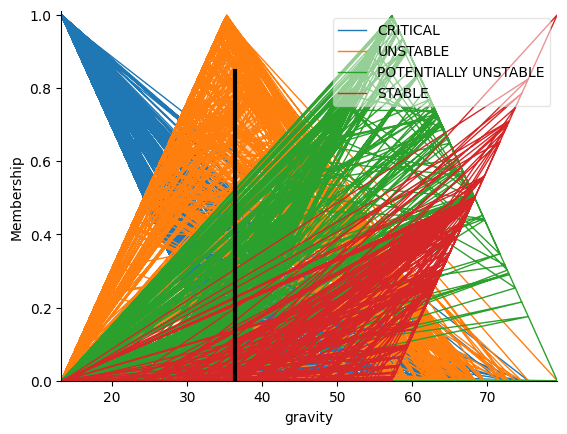

In [269]:
membership["consequent"]["gravity"].view(sim=sim)

In [229]:
fuzz.simulation()

index | anwser | fuzz
1 | 33.5156 | 36.35734238707534
2 | 68.3047 | 36.446442288268905
3 | 30.3124 | 36.4780291214483
4 | 24.096 | 36.45074591358366
error in index 5, from: 51.3438 , 21.0420
error in index 6, from: 33.9139 , 21.6708
error in index 7, from: 47.8693 , 20.7103
error in index 8, from: 18.2070 , 6.6324
error in index 9, from: 170.9688 , 20.3857
10 | 43.803 | 36.481458668159014
11 | 29.7937 | 36.35734238707533
error in index 12, from: 47.2781 , 6.0048
13 | 47.8688 | 36.452886050929955
14 | 46.8314 | 36.384880788373756
15 | 45.4064 | 36.47453693500622
16 | 38.362 | 36.491252843207526
17 | 54.6081 | 36.49425980538439
error in index 18, from: 8.6152 , 21.0186
19 | 34.6175 | 36.357342387075334
20 | 49.3373 | 36.35734238707533
21 | 66.7618 | 36.451094028433594
22 | 27.3276 | 36.477162786922186
error in index 23, from: 28.5481 , 8.5668
24 | 37.8699 | 36.48432822447877
error in index 25, from: 181.2773 , 3.6665
error in index 26, from: 180.7511 , 8.4717
error in index 27, from: 46.